In [540]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
mongo = client.hai

In [541]:
import time
time.time()

1512705246.2567947

In [755]:
start_time = int(time.time()) - 3600*24*5
end_time = int(time.time()) - 3600*24
username = "sean"

In [756]:
query = {"user_name": username, "pose":{"$exists": True}, "detections":{"$exists": True}, "time": {"$gt": start_time, "$lt": time.time()}}
cams = mongo.images.find(query).distinct("cam_id")
print(cams)
#cams = ["ipcam0"]#["webcam0"]

['webcam0', 'ipcam0']


In [757]:
import os
import sys

sys.path.append("..")
os.chdir("/home/sean/HAI/main_server/hai")

In [758]:
%load_ext autoreload
%autoreload 2

import scipy.misc
import matplotlib.pyplot as plt
import controllers.learner.datasets as ds
ds.port = 27017

%matplotlib inline

image_data, time_data = ds.get_event_images3(username, cams, start_time, end_time, stride=5, size=5, skip_incomplete=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
skipped: 27024 picked: 42095
total: 69120


In [759]:
import numpy as np

time_data = np.array(time_data)# - start_time
print(time_data[:10])
print(len(image_data), len(time_data))

[1512333116 1512333121 1512333126 1512333136 1512333146 1512333151
 1512333156 1512333161 1512333166 1512333176]
42095 42095


In [760]:
def data2vec(data):
        body_pose = data["pose"]["body"]
        if len(body_pose) > 0:
            top_pts, top_c  = None, 0
            for bp in body_pose:
                pt_mat = np.array(bp)
                c_sum = np.max(pt_mat, axis=0)[1] - np.min(pt_mat, axis=0)[0]
                #c_sum = sum(b_pts[2::3])
                #print(b_pts[2::3])
                if c_sum > top_c or top_pts is None:
                    top_c = c_sum
                    top_pts = pt_mat.flatten()
            
            return top_pts
        else:
            return [0] * (3*18)
        
def data2vec2(data, pose=True):
        dets = data["detections"]
        top_person = None
        
        for det in dets:
            if det["label"] == "person" and det["passed"]:
                if top_person is None or det["confidence"] > top_person["confidence"]:
                    top_person = det
        
        if top_person is None:
            if pose:
                return np.zeros(1024+18*3), None, None, None
            else:
                return np.zeros(1024), None, None, None
        else:
            if pose:
                if "pose_body_index" in top_person:
                    top_pose = np.array(data["pose"]["body"][top_person["pose_body_index"]]).flatten()
                    #print(top_pose)
                    vec = np.concatenate([top_person["action_vector"], top_pose])
                    box = top_person["action_crop"]
                    return vec, box, data["pose"]["body"][top_person["pose_body_index"]], top_person["action"]
                else:
                    #print(top_person)
                    return np.concatenate([top_person["action_vector"], np.zeros(18*3)]), top_person["box"], None, top_person["action"]
            else:
                return top_person["action_vector"]

In [761]:
import numpy as np
pose_pts = []
image_data2 = []
time_data2 = []
meta = []

for i, data in enumerate(image_data):
    v1 = []
    v2 = []
    metas = []
    for cam_i in range(len(cams)):
        pt, box, pose, act = data2vec2(data[cam_i])
        metas.append([box, pose, act])
        #pts.extend(pt)
        v1.extend(pt[:1024])
        v2.extend(pt[1024:])
    pts = np.array(v1 + v2).flatten()
        
    meta.append(metas)
    pose_pts.append(pts)
    time_data2.append(time_data[i])
    image_data2.append(data)
time_data2 = np.array(time_data2)
print(time_data2[:10])

[1512333116 1512333121 1512333126 1512333136 1512333146 1512333151
 1512333156 1512333161 1512333166 1512333176]


In [762]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def plot(x):
    pca = PCA(n_components=5)
    tsne = TSNE(n_components=2)
    x = x.reshape([-1, x.shape[-1]])
    x = StandardScaler().fit_transform(x)
    x = pca.fit_transform(x)
    #x = tsne.fit_transform(x)
    #x = x.reshape([-1, 5])
    #for t in range(start_time, end_time, 3600):
    #cond = np.where(np.logical_and(time_data2>t, time_data2<=t+3600))
    #plt.scatter(x[cond,0],x[cond,1], label=t)
    #plt.scatter(x[:,0], x[:, 1])
    fig, ax = plt.subplots(figsize=(18, 2))
    ax.imshow(x.T, aspect='auto')

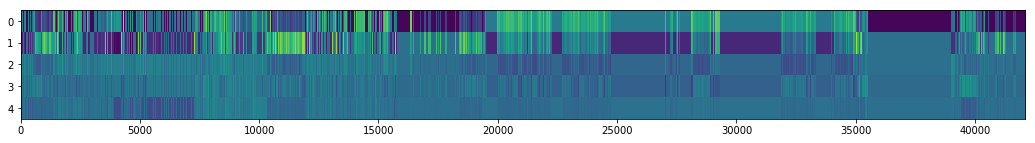

In [763]:
%matplotlib inline
pose_mat = np.array(pose_pts)
plot(pose_mat)
#x = StandardScaler().fit_transform(pose_mat)
#plt.imshow(x.T, aspect='auto')

In [764]:
import cv2
lines = [[0, 1], [1, 2], [2, 3], [3, 4], [1, 5], [5, 6], [6, 7], [0, 14], [14, 16], [0, 15], [15, 17], [1, 8], [8, 9], [9, 10], [1, 11], [11, 12], [12, 13]]

def draw_pose(img, pose, box, text):
    if pose is not None:
        for i, (pt1_i, pt2_i) in enumerate(lines):
            pt1 = pose[pt1_i]
            pt2 = pose[pt2_i]

            if pt1[2] < 0.05 or pt2[2] < 0.05:
                continue

            a = np.array([[[i*20, 255, 255]]], dtype=np.uint8)
            col = cv2.cvtColor(a, cv2.COLOR_HSV2BGR)[0][0]
            col = (int(col[0]), int(col[1]), int(col[2]))
            img = cv2.circle(img, (int(pt1[0]), int(pt1[1])), 3, col, -1)
            img = cv2.circle(img, (int(pt2[0]), int(pt2[1])), 3, col, -1)
            img = cv2.line(img, (int(pt1[0]), int(pt1[1])), (int(pt2[0]), int(pt2[1])), col, 2)
    
    if box is not None:
        img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 5)
        
    img = cv2.putText(img, text, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2)
    
    return img

In [794]:
print(cams)
#time.sleep(30)
latest_imgs = []
for cam in cams:
    query = {"user_name": username, "pose.body":{"$exists": True}, "detections":{"$exists": True}, "cam_id":cam}
    latest_img = mongo.images.find(query).limit(1).sort([("time",-1)])[0]
    latest_imgs.append(latest_img)
    #print(latest_img)

['webcam0', 'ipcam0']


/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


2156 (42095, 2156)
---
0.0
cnn dist 2.40862181735
pose dist 0.0537099861513
0.0537099861513
lab playing guitar
lab situp
top 20204 2
(42095, 2048) (42095, 108) (108,)
---
0.2


/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


cnn dist 0.501833731664
pose dist 0.125955419002
0.201131081534
lab texting
lab None
top 1294 2
(42095, 2048) (42095, 108) (108,)
---
0.4


/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


cnn dist 0.501833731664
pose dist 0.125955419002
0.276306744067
lab texting
lab None
top 1294 2
(42095, 2048) (42095, 108) (108,)
---
0.6


/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


cnn dist 0.273256824299
pose dist 0.285687496669
0.278229093247
lab brushing hair
lab None
top 18680 2
(42095, 2048) (42095, 108) (108,)
---
0.8


/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


cnn dist 0.273256824299
pose dist 0.285687496669
0.275742958773
lab brushing hair
lab None
top 18680 2
(42095, 2048) (42095, 108) (108,)
---
1.0


/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


cnn dist 0.252801681627
pose dist 0.709254945241
0.252801681627
lab getting a tattoo
lab None
top 668 2
(42095, 2048) (42095, 108) (108,)


/home/sean/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


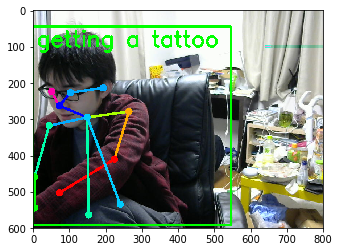

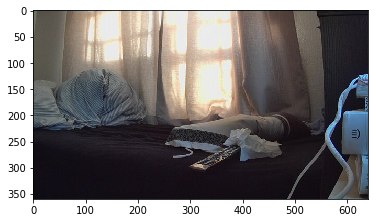

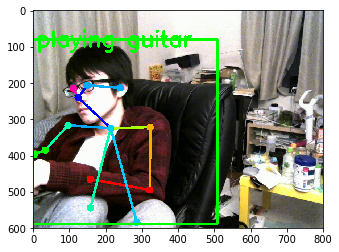

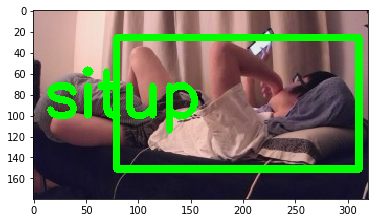

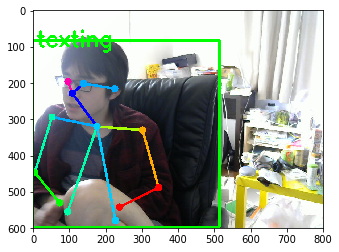

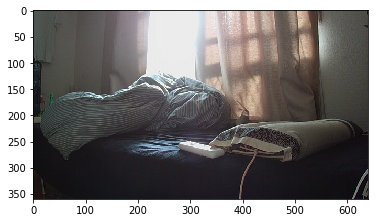

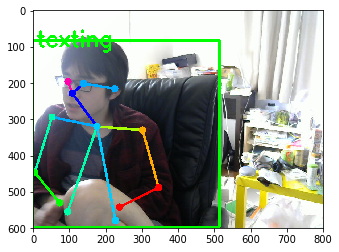

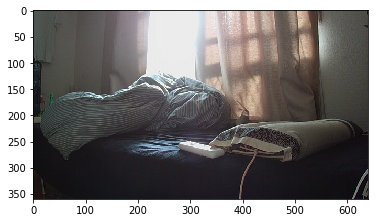

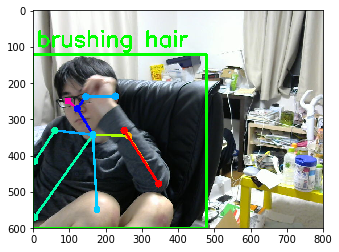

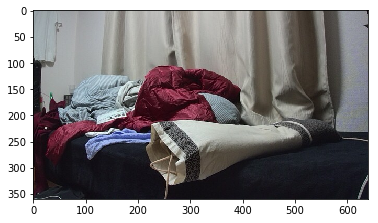

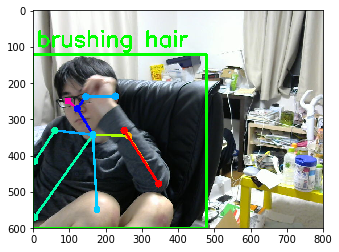

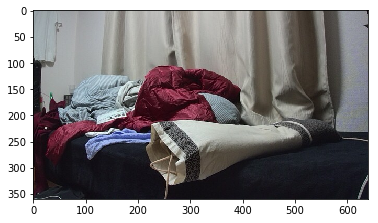

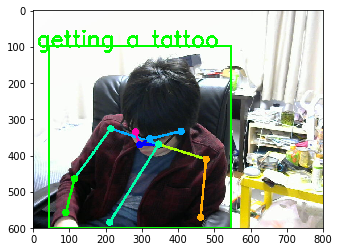

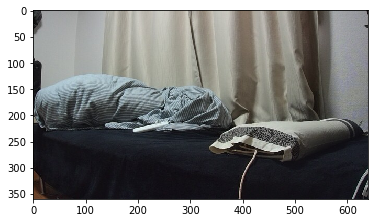

In [796]:
from scipy.misc import imread
pts1 = []
pts2 = []

for latest_img in latest_imgs:
    img = imread("images/raw_images/" + latest_img["filename"])
    vec, query_box, query_pose, act = data2vec2(latest_img)
    
    plt.figure()
    img = draw_pose(img, query_pose, query_box, act)
    plt.imshow(img)
    
    pts1.extend(vec[:1024])
    pts2.extend(vec[1024:])

pts = pts1 + pts2
from sklearn.pipeline import Pipeline
from scipy.misc import imread
from scipy.spatial.distance import cosine

print(len(pts), pose_mat.shape)

def show_similar(cnn_weight):
    #print(cnn_weight)
    #corr = np.dot(x, feats)
    #pipe1 = Pipeline([("pca", PCA(n_components=50))])
    pipe1 = Pipeline([("std", StandardScaler())])
    pipe2 = Pipeline([("std", StandardScaler())])
    b = len(cams) * 1024
    x1 = pipe1.fit_transform(pose_mat[:,:b])
    #x1 = pose_mat[:,:b]
    x2 = pipe2.fit_transform(pose_mat[:,b:])
    #feats1 = pts[:b]#
    feats1 = pipe1.transform([pts[:b]])[0]
    feats2 = pipe2.transform([pts[b:]])[0]
    #feats1 = pts[:1024]
    #feats2 = pts[1024:]
    #print(pts[:1024])
    #print("sp", np.array(feats2).shape, x2.shape)
    #print(((feats2[1024:] - x2[:,1024:])**2.0).shape)
    #bad_indices = np.where(np.isnan(np.mean((feats2[1024:] - x2[:,1024:])**2.0, axis=1)))
    #print(bad_indices)
    #corr = cnn_weight * np.mean((feats[:1024] - x[:,:1024])**2.0, axis=1) + (1.0-cnn_weight) * np.mean((feats[1024:] - x[:,1024:])**2.0, axis=1)
    cnn_dist = np.mean((feats1 - x1)**2.0, axis=1)
    
    corr = cnn_weight * cnn_dist
    #corr = cnn_weight * 1.0/(np.dot(x1, feats1)+1e-3)#p.stack([cosine(x, feats1) for x in x1])
    pose_dist = np.mean((feats2 - x2)**2.0, axis=1)
    corr += (1.0-cnn_weight) * pose_dist
    
    #print(corr[:20])
    top_match = np.argmin(corr, axis=0)
    print("cnn dist", cnn_dist[top_match])
    print("pose dist", pose_dist[top_match])
    #print(top_match)
    print(corr[top_match])
    #top_match = image_data2[top_match]
    for i, image in enumerate(image_data2[top_match]):
        img = imread("images/raw_images/" + image["filename"])
        img = draw_pose(img, meta[top_match][i][1], meta[top_match][i][0], meta[top_match][i][2])
        print("lab", meta[top_match][i][2])
        plt.figure()
        plt.imshow(img)
    #print(top_match, pts[:10], x1[top_match, :10])
    print("top", top_match, len(image_data2[top_match]))
    #print("pose_mat", pose_mat[top_match, :10])
    print(x1.shape, x2.shape, feats2.shape)
    #print(str(np.mean((feats1 - x1[top_match])**2.0, axis=1)), str(np.mean((feats2 - x2[top_match])**2.0, axis=1)))

#print(pose_mat[:,:10])
#show_similar(1)
for w in np.arange(0.0, 1.01, 0.2):
    print("---")
    print(w)
#    sys.stdout.flush()
    show_similar(w)

In [784]:
from scipy.misc import imread
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def lineplot(x):
    pca = PCA(n_components=1)
    tsne = TSNE(n_components=1)
    x = x.reshape([-1, x.shape[-1]])
    x = StandardScaler().fit_transform(x)
    x = pca.fit_transform(x)
    #x = tsne.fit_transform(x)
    #for t in range(start_time, end_time, 3600):
    #    cond = np.where(np.logical_and(time_data2>t, time_data2<=t+3600))
    
    plt.figure(figsize=(18, 16))
    ax = plt.gca()

    for i, xx in enumerate(x):
        #print("images/raw_images/" + image_data2[i][0]["filename"])
        img = imread("images/raw_images/" + image_data2[i][0]["filename"])
        im = OffsetImage(img, zoom=0.1)
        ab = AnnotationBbox(im, (time_data2[i], xx), xycoords='data', frameon=False)
        ax.add_artist(ab)

    ax.update_datalim(np.column_stack([time_data2, x]))
    ax.autoscale()
    plt.show()
    
    plt.plot(time_data2, x, "o")
    
lineplot(np.array(pose_pts))

KeyboardInterrupt: 